## Imports:

In [1]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud

from PIL import Image

## Constants:

In [2]:
EXAMPLE = 'SpamData/01_Processing/practice_email.txt'

# Paths
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2/'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

# Categories
SPAM_CAT = 0
HAM_CAT = 1

# file
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'
TRAINING_DATA_FILE  = 'SpamData/02_Training/tain-data.txt'
TESTING_DATA_FILE  = 'SpamData/02_Training/test-data.txt'

# masks for word cloud
WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# custom font
CUSTOM_FONT = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# size of vocabulary
VOCAB_SIZE = 2501

## Reading Files

In [3]:
stream = open(EXAMPLE, encoding='utf-8')
is_body = False
body_lines = []
for line in stream:
    if is_body:
        body_lines.append(line)
    if line == '\n':
        is_body = True
stream.close()
body = '\n'.join(body_lines)
body

'\n\nDear Mr Still\n\n\n\nGood tidings to you and all your staff for the festive season ahead (Christmas).\n\nNow to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa\'s Grotto" in your store.\n\nBut WAIT! You\'re probably thinking: "What makes him so special?"\n\nWell, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.\n\nYou will note also, from the enclosed sketch, that I have radically redesigned Santa\'s outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.\n\nI look forward to hearing from you.\n\n\n\nBest wishes\n\nRobin Cooper\n\n[Excerpt from 

## Generator Function

In [4]:
def email_body_generator(path):
    """
    Generator function that yields email filenames and their corresponding bodies from a given directory.

    Parameters:
        path (str): The path to the directory containing email files.

    Yields:
        tuple: A tuple containing the filename and email body as a string.
    """
    for root, dirnames, filenames in walk(path):
        
        for filename in filenames:
            filepath = join(root, filename)
            
            stream  = open(filepath, encoding='latin-1')  
            is_body = False
            body_lines = []
            for line in stream:
                if is_body:
                    body_lines.append(line)
                if line == '\n':
                    is_body = True
            stream.close()
            
            email_body = '\n'.join(body_lines)
                
            yield filename, email_body

In [5]:
def df_from_directory(path, classification):
    """
    Create a pandas DataFrame from email files in a directory.

    Parameters:
        path (str): The path to the directory containing email files.
        classification (str): The classification label to assign to all emails in the DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing email messages and their classifications.
    """
    rows = []
    rows_names = []
    
    for filename, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CLASSIFICATION':classification})
        rows_names.append(filename)
        
    return pd.DataFrame(rows, index=rows_names)

In [6]:
spam_emails = pd.concat([df_from_directory(SPAM_2_PATH, SPAM_CAT), df_from_directory(SPAM_1_PATH, SPAM_CAT)], axis=0)
ham_emails = pd.concat([df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT), df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)], axis=0)

In [7]:
ham_emails.shape

(3901, 2)

In [8]:
data = pd.concat([ham_emails, spam_emails], axis=0)

In [9]:
data.shape

(5799, 2)

In [10]:
data.head()

,MESSAGE,CLASSIFICATION
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",1
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",1
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,1
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,1
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",1


## Data Cleaning : Checking for Missing Values

In [11]:
data.MESSAGE.isna().values.sum() # checking for None values

0

In [12]:
(data.MESSAGE.str.len() == 0).sum()

3

In [13]:
data[data.MESSAGE.str.len() == 0]

,MESSAGE,CLASSIFICATION
cmds,,1
cmds,,0
cmds,,0


## Remove System File Entries from DataFrame

In [14]:
data.drop(['cmds'], inplace=True)

## Add Document IDs to Track Emails in Dataset

In [15]:
data['DOC_ID'] = range(0, len(data.index))
data['FILE_NAME'] = data.index

In [16]:
data.set_index('DOC_ID', inplace=True)

In [17]:
data

,MESSAGE,CLASSIFICATION,FILE_NAME
DOC_ID,,,
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",1,00001.7c53336b37003a9286aba55d2945844c
1,"Martin A posted:\n\nTassos Papadopoulos, the G...",1,00002.9c4069e25e1ef370c078db7ee85ff9ac
2,Man Threatens Explosion In Moscow \n\n\n\nThur...,1,00003.860e3c3cee1b42ead714c5c874fe25f7
3,Klez: The Virus That Won't Die\n\n \n\nAlready...,1,00004.864220c5b6930b209cc287c361c99af1
4,"> in adding cream to spaghetti carbonara, whi...",1,00005.bf27cdeaf0b8c4647ecd61b1d09da613
...,...,...,...
5791,<html>\n\n<head>\n\n<title>Toy</title>\n\n</he...,0,00496.1a37de098f6c8847c3c7839d73cc7106
5792,<html>\n\n<head>\n\n<title>Untitled Document</...,0,00497.ebf699da617b11135f3aa9173b9781b9
5793,This is an HTML email message. If you see thi...,0,00498.48c3098854d339353f1a28a13b196017


In [18]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualized

In [19]:
category_names = ['Spam', 'Legit Mail']
categories_counts = data.CLASSIFICATION.value_counts()
categories_counts

1    3900
0    1896
Name: CLASSIFICATION, dtype: int64

In [20]:
legit_mail_size = categories_counts.values[0]
spam_mail_size = categories_counts.values[1]
sizes = [spam_mail_size, legit_mail_size]
colors = ['#A6D0DD', '#FF6D60']

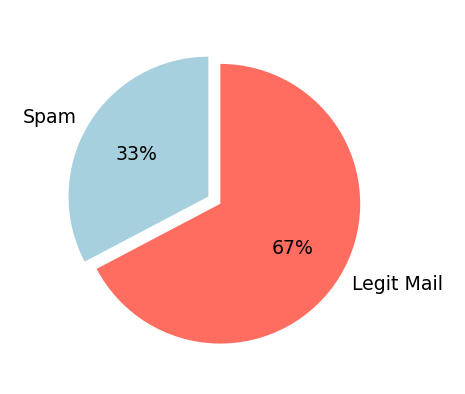

In [21]:
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes,
        labels=category_names,
        textprops={'fontsize':6},
        startangle=90,
        autopct="%1.0f%%",
        explode=[0, 0.1], 
        colors=colors)
plt.show()

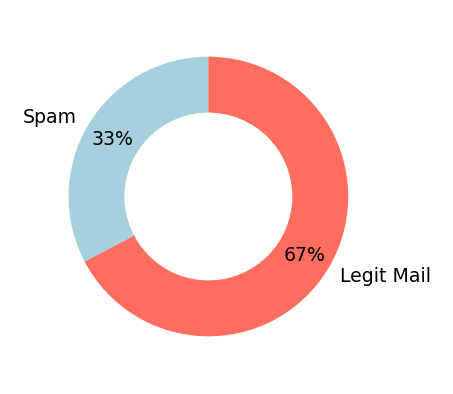

In [22]:
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes,
        labels=category_names,
        textprops={'fontsize':6},
        startangle=90,
        autopct="%1.0f%%", 
        colors=colors,
        pctdistance=0.8)
circle = plt.Circle(xy=(0,0),
                    radius=0.6,
                    fc='white')
plt.gca().add_artist(circle)
plt.show()

## Natural Language Processing (NLP) :

### Text Pre-Processing :

### Download the NLTK Resources (Tokenizer and Stopwords)

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\momoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\momoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# nltk.download('gutenberg')
# nltk.download('shakespeare')

### Tokenizing

In [26]:
msg = '<a>All words Making</a> aziz</b><tr> moves going and, big player .'
words = word_tokenize(msg.lower())

### Removing Stop Words

In [27]:
stop_words= set(stopwords.words('english'))
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
filtered_words

['<',
 '>',
 'words',
 'making',
 '<',
 '/a',
 '>',
 'aziz',
 '<',
 '/b',
 '>',
 '<',
 'tr',
 '>',
 'moves',
 'going',
 ',',
 'big',
 'player',
 '.']

## Word Stems and Word Stemming

In [28]:
stop_words= set(stopwords.words('english'))
filtered_words = []

stemmer = SnowballStemmer('english')

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['word', 'make', 'aziz', 'tr', 'move', 'go', 'big', 'player']

### Removing HTML tags from E-mails

In [29]:
soup = BeautifulSoup(msg, 'html.parser')
soup.get_text()

'All words Making aziz moves going and, big player .'

In [30]:
def clean_message(message: str, stemmer=SnowballStemmer('english'), stop_words=set(stopwords.words('english'))):
    """
    Clean and preprocess a text message.

    Parameters:
        message (str): The input text message to be cleaned.
        stemmer (SnowballStemmer, optional): A stemmer for word stemming (default: SnowballStemmer('english')).
        stop_words (set, optional): A set of stopwords to remove from the text (default: English stopwords).

    Returns:
        list: A list of cleaned and preprocessed words from the input message.
    """

    # Remove HTML tags using BeautifulSoup
    message = BeautifulSoup(message, 'html.parser').get_text()

    # Initialize an empty list to store filtered words
    filtered_words = []

    # Tokenize the message into words and convert them to lowercase
    words = word_tokenize(message.lower())

    # Iterate through the words
    for word in words:
        # Check if the word is not in the list of stopwords and consists of alphabetic characters
        if word not in stop_words and word.isalpha():
            # Stem the word using the provided stemmer
            stemmed_word = stemmer.stem(word)
            # Append the stemmed word to the filtered_words list
            filtered_words.append(stemmed_word)

    return filtered_words

### Applying Cleaning and Tokenization to all Messages

In [31]:
%%time

nested_list = data.MESSAGE.apply(clean_message)
nested_list

C:\Users\momoh\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\momoh\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 58.3 s


DOC_ID
0       [date, wed, aug, chris, garrigu, ca, reproduc,...
1       [martin, post, tasso, papadopoulo, greek, scul...
2       [man, threaten, explos, moscow, thursday, augu...
3       [klez, virus, wo, die, alreadi, prolif, virus,...
4       [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [toy, abc, good, morn, america, rank, christma...
5792    [untitl, document, let, mortgag, lender, compe...
5793    [html, email, messag, see, mail, client, suppo...
5794    [famous, ebay, market, learn, sell, complet, a...
5795    [hello, chines, tradit, äúïëò, iän, respons, r...
Name: MESSAGE, Length: 5796, dtype: object

### Using Logic to Slice DataFrames:

In [32]:
doc_ids_spam = data.index[data.CLASSIFICATION == 0]
doc_ids_ham = data.index[data.CLASSIFICATION == 1]

In [33]:
doc_ids_ham

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index:

In [34]:
nested_list_spam = nested_list[doc_ids_spam]
nested_list_ham = nested_list[doc_ids_ham]

In [35]:
words_spam = pd.Series([word for message in nested_list_spam for word in message])
words_ham = pd.Series([word for message in nested_list_ham for word in message])

print(f'Number of Spam words : {words_spam.nunique()}')
print(f'Number of Ham words : {words_ham.nunique()}')
print(f'Most popular spam words are : {words_spam.value_counts().index[:11]}')
print(f'Most popular ham words are : {words_ham.value_counts().index[:11]}')

Number of Spam words : 13185
Number of Ham words : 20703
Most popular spam words are : Index(['email', 'http', 'free', 'click', 'receiv', 'list', 'get', 'pleas',
       'busi', 'order', 'mail'],
      dtype='object')
Most popular ham words are : Index(['http', 'use', 'list', 'one', 'get', 'mail', 'would', 'like', 'messag',
       'work', 'time'],
      dtype='object')


# WordCloud of Ham and Spam Messages:

In [36]:
words_spam = [word.upper() for message in nested_list_spam for word in message]
words_ham = [word.upper() for message in nested_list_ham for word in message]

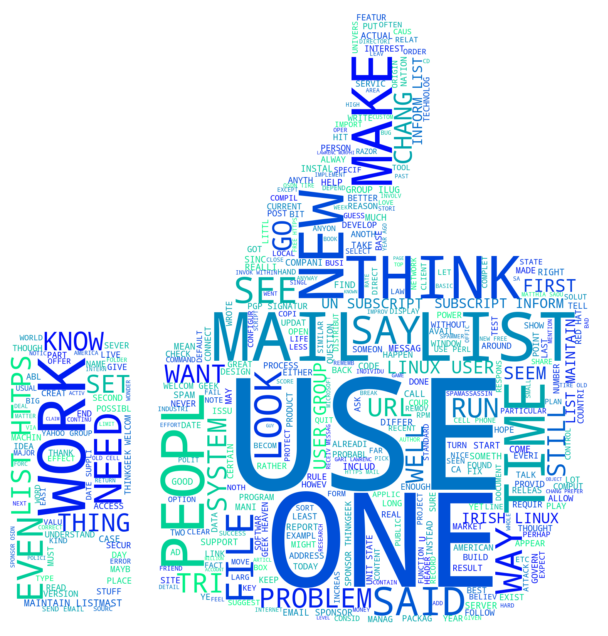

In [37]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
img_array = np.array(image_mask)

wordcloud = WordCloud(background_color='white',
                      mask=img_array,
                      max_words=400, 
                      colormap='winter')
wordcloud.generate(' '.join(words_ham))

plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear');

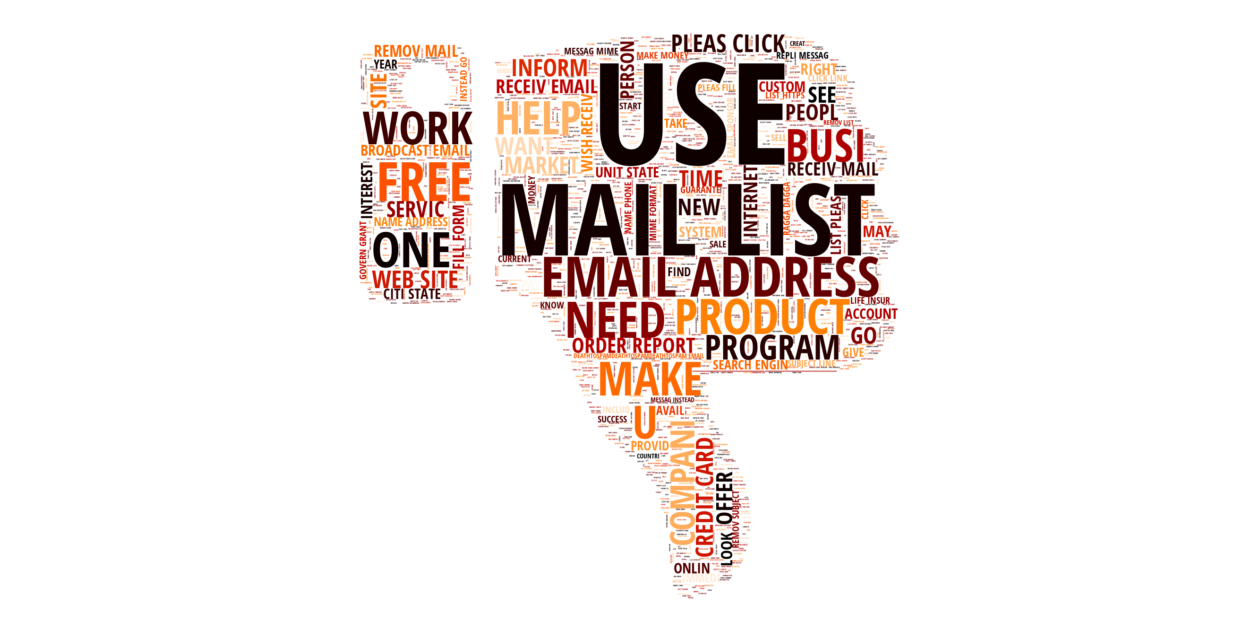

In [38]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
img_array = np.array(image_mask)

wordcloud = WordCloud(background_color='white',
                      mask=img_array,
                      max_words=2000, 
                      colormap='gist_heat',
                      max_font_size=300,
                      font_path=CUSTOM_FONT)
wordcloud.generate(' '.join(words_spam).upper())

plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear');

## Generate Vocabulary and Dictionary

In [39]:
flat_stemmed_list = [word for message in nested_list for word in message]
unique_words = pd.Series(flat_stemmed_list).value_counts()
unique_words.head()

http     9511
use      5019
list     4851
email    4367
get      4200
dtype: int64

In [40]:
top_used_words = unique_words[:VOCAB_SIZE]
top_used_words.head(10)

http     9511
use      5019
list     4851
email    4367
get      4200
mail     3983
one      3907
free     3202
time     3042
work     2883
dtype: int64

## Create Vocabulary DataFrame:

In [41]:
words_id = list(range(0,VOCAB_SIZE))
vocab_df = pd.DataFrame({'VOCAB_WORD':top_used_words.index, 
                         'FREQUENCY':top_used_words.values}, index=words_id)
vocab_df.index.name = 'WORDS_ID'
vocab_df

,VOCAB_WORD,FREQUENCY
WORDS_ID,,
0,http,9511
1,use,5019
2,list,4851
3,email,4367
4,get,4200
...,...,...
2496,palm,43
2497,heat,43
2498,fiction,43


## Save Vocabulary as CSV File:

In [42]:
vocab_df.to_csv(WORD_ID_FILE)

## Generate Features & Sparse Matrix
### Creating a DataFrame with one word per Column

In [43]:
type(nested_list)

pandas.core.series.Series

In [44]:
words_column_df = pd.DataFrame.from_records(nested_list.to_list())
words_column_df

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,date,wed,aug,chris,garrigu,ca,reproduc,error,repeat,like,...,None,None,None,None,None,None,None,None,None,None
1,martin,post,tasso,papadopoulo,greek,sculptor,behind,plan,judg,limeston,...,None,None,None,None,None,None,None,None,None,None
2,man,threaten,explos,moscow,thursday,august,pm,moscow,ap,secur,...,None,None,None,None,None,None,None,None,None,None
3,klez,virus,wo,die,alreadi,prolif,virus,ever,klez,continu,...,None,None,None,None,None,None,None,None,None,None
4,ad,cream,spaghetti,carbonara,effect,pasta,make,pizza,jump,carbonara,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,toy,abc,good,morn,america,rank,christma,toy,n,new,...,None,None,None,None,None,None,None,None,None,None
5792,untitl,document,let,mortgag,lender,compet,busi,receiv,email,advertis,...,None,None,None,None,None,None,None,None,None,None
5793,html,email,messag,see,mail,client,support,html,messag,thank,...,None,None,None,None,None,None,None,None,None,None
5794,famous,ebay,market,learn,sell,complet,auction,market,chanc,join,...,None,None,None,None,None,None,None,None,None,None


## Splitting Data into Training and Testing DataSets:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(words_column_df , data.CLASSIFICATION, test_size=0.3, random_state=42)

In [46]:
X_test.index.name = X_train.index.name = 'DOC_ID'

In [47]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,use,individu,busi,investig,eed,get,truth,anyon,internet,pleas,...,None,None,None,None,None,None,None,None,None,None
4220,vigor,ad,vigor,herbal,sex,enhancersdirect,lab,offer,uniqu,product,...,None,None,None,None,None,None,None,None,None,None
2484,recent,read,novel,exact,sorta,thing,happen,ca,rememb,call,...,None,None,None,None,None,None,None,None,None,None
2418,url,http,date,toumai,hail,oldest,ancestor,stir,ancient,scientif,...,None,None,None,None,None,None,None,None,None,None
5110,norton,ad,attent,must,comput,user,new,special,packag,deal,...,None,None,None,None,None,None,None,None,None,None


In [48]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    1
2418    1
5110    0
Name: CLASSIFICATION, dtype: int64

### Create a Sparse Matrix for the Training Data:

In [49]:
word_index = pd.Index(vocab_df.VOCAB_WORD)

In [50]:
def make_sparse_matrix(df : pd.DataFrame, indexed_words : pd.Index, labels : pd.Series):
    """
    Converts a DataFrame of text data into a sparse matrix representation.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing text data.
        indexed_words (pd.Index): A pandas Index containing unique words for indexing.
        labels (pd.Series): A pandas Series containing labels or categories for each document.

    Returns:
        pd.DataFrame: A sparse matrix representation in DataFrame format.
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            
            if word in word_set:
                
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'DOC_ID':doc_id, 'WORD_ID':word_id, 'CATEGORY':category, 'OCCURENCE':1}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

In [51]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)
sparse_train_df.head()

Wall time: 15min 34s


,DOC_ID,WORD_ID,CATEGORY,OCCURENCE
0,4844,1736,0,1
1,4844,74,0,1
2,4844,148,0,1
3,4844,1736,0,1
4,4844,2007,0,1


In [52]:
sparse_train_df.shape

(435255, 4)

## Combine Occurences with the Pandas Groupby Method:

In [53]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'CATEGORY']).sum()
train_grouped.reset_index(inplace=True)
train_grouped.head()

,DOC_ID,WORD_ID,CATEGORY,OCCURENCE
0,0,1,1,2
1,0,2,1,1
2,0,4,1,1
3,0,5,1,1
4,0,6,1,2


In [54]:
train_grouped.shape

(261424, 4)

## Save Train Data as .txt File:

In [55]:
np.savetxt(fname=TRAINING_DATA_FILE, X=train_grouped, fmt='%d')

### Create a Sparse Matrix for the Test Data:

In [56]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)
sparse_test_df.head()

Wall time: 6min 41s


,DOC_ID,WORD_ID,CATEGORY,OCCURENCE
0,4675,1,0,1
1,4675,421,0,1
2,4675,20,0,1
3,4675,801,0,1
4,4675,4,0,1


In [57]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'CATEGORY']).sum()
test_grouped.reset_index(inplace=True)
test_grouped.head()

,DOC_ID,WORD_ID,CATEGORY,OCCURENCE
0,8,0,1,2
1,8,1,1,3
2,8,3,1,1
3,8,4,1,1
4,8,6,1,2


## Save Test Data as .txt File:

In [58]:
np.savetxt(fname=TESTING_DATA_FILE, X=test_grouped, fmt='%d')